In [1]:
import FailtogetConv_error as fe
fe.fail_to_get_conv()

1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
from glob import glob
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext tensorboard

In [3]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

In [4]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
os.listdir('../dataset/cifar/')

['labels.txt', 'test', 'train']

In [7]:
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

len(train_paths), len(test_paths)

(1000, 1000)

In [8]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [9]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [10]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [11]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [12]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [16]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 2.3115 - accuracy: 0.0930 - val_loss: 2.2953 - val_accuracy: 0.1129
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 2.2678 - accuracy: 0.1229 - val_loss: 2.2699 - val_accuracy: 0.1200
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 2.2398 - accuracy: 0.1612 - val_loss: 2.1908 - val_accuracy: 0.1855
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 2.1438 - accuracy: 0.1963 - val_loss: 2.0977 - val_accuracy: 0.2167
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 2.0897 - accuracy: 0.2128 - val_loss: 1.9799 - val_accuracy: 0.2601
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 1.9949 - accuracy: 0.2521 - val_loss: 1.9240 - val_accuracy: 0.3085
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 1.961

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 31}

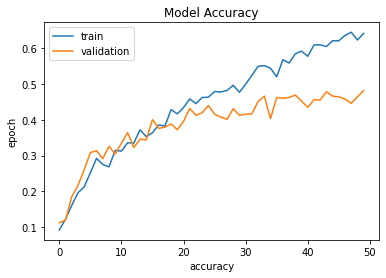

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

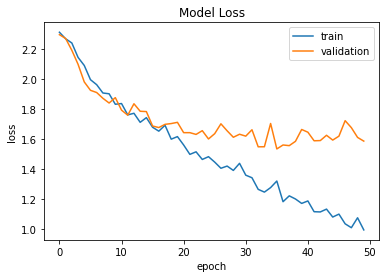

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

## Predict

- image를 직접 load해서 넣는 방법

In [22]:
path = test_paths[0]
path

'../dataset/cifar/test/0_cat.png'

In [23]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [24]:
image = image[tf.newaxis, ...]
image.shape

TensorShape([1, 32, 32, 3])

In [25]:
pred = model.predict(image)
pred.shape

(1, 10)

In [27]:
np.argmax(pred)

5

- generator에서 데이터를 가져오는 방법

In [28]:
test_image, test_label = next(iter(test_dataset))
test_image.shape

TensorShape([32, 32, 32, 3])

In [29]:
pred = model.predict(test_image)
pred.shape

(32, 10)

In [31]:
np.argmax(pred[0])

5

- generator에 넣는 방법

In [33]:
pred = model.predict_generator(test_dataset.take(1))
pred.shape

Instructions for updating:
Please use Model.predict, which supports generators.


(32, 10)

In [35]:
np.argmax(pred[0])

5

## Eval

In [38]:
image, label = next(iter(test_dataset))
evals = model.evaluate(image, label)
evals

1/1 [==============================] - 0s 2ms/step - loss: 1.4508 - accuracy: 0.4688


[1.450776219367981, 0.46875]

## Saving Model

In [39]:
save_path = 'my_model.h5'
model.save(save_path, include_optimizer=True)

In [40]:
model = tf.keras.models.load_model('my_model.h5')

## Saving Model 2

In [41]:
model.save_weights('model_weights.h5')

In [42]:
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [43]:
from tensorflow.keras.models import model_from_json

In [44]:
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

In [45]:
model.load_weights('model_weights.h5')

## H5 모델

In [46]:
import h5py

In [47]:
model_file = h5py.File('my_model.h5', 'r+')
model_file.keys()

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>

In [48]:
model_file['model_weights'].keys()

<KeysViewHDF5 ['activation', 'activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'dense', 'dense_1', 'dropout', 'dropout_1', 'dropout_2', 'flatten', 'input_1', 'max_pooling2d', 'max_pooling2d_1']>

In [49]:
model_file['model_weights']['conv2d']['conv2d'].keys()

<KeysViewHDF5 ['bias:0', 'kernel:0']>

In [50]:
model_file['model_weights']['conv2d']['conv2d']['kernel:0']

<HDF5 dataset "kernel:0": shape (3, 3, 3, 32), type "<f4">

In [51]:
weight = np.array(model_file['model_weights']['conv2d']['conv2d']['kernel:0'])
weight

array([[[[-4.41373698e-03, -1.81092527e-02, -1.15045622e-01,
          -1.02968328e-01,  1.18879750e-01,  8.07792842e-02,
          -3.01032625e-02,  9.46301445e-02, -4.95156050e-02,
           3.11887953e-02,  1.04578614e-01, -8.81722867e-02,
          -2.81464271e-02, -8.03300142e-02,  1.15343958e-01,
           1.48306236e-01,  1.18911266e-01,  5.09372652e-02,
          -1.08802496e-02,  5.99147081e-02,  3.34208682e-02,
           1.95396859e-02, -7.50395060e-02,  3.57208513e-02,
           6.93622977e-03, -1.15741856e-01,  1.74223393e-01,
           1.43920571e-01, -1.18670605e-01, -4.52235632e-04,
          -5.72678931e-02, -5.97573742e-02],
         [ 8.79210904e-02, -1.27498284e-01, -1.33752376e-01,
          -8.61667544e-02, -1.78839974e-02, -4.66508493e-02,
           6.60564080e-02, -1.22637324e-01, -2.63224822e-02,
           1.24734631e-02,  1.17831290e-01, -3.92131768e-02,
          -1.34034872e-01,  5.40631562e-02, -1.74319923e-01,
          -1.50423095e-01,  1.55014426e-